## Necessary Imports 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import glob
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Conv2d,ReLU,MaxPool2d,Linear,Dropout,Sequential

In [2]:
dataset = 'DATASET/'

## Data Preparation

In [3]:
data_map = []
for sub_dir_path in glob.glob(dataset+"/TRAIN/"+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

,dirname,path
0,tree,DATASET//TRAIN/tree/00000106.jpg
1,tree,DATASET//TRAIN/tree/00000085.jpg
2,tree,DATASET//TRAIN/tree/00000098.jpg
3,tree,DATASET//TRAIN/tree/File10.jpg
4,tree,DATASET//TRAIN/tree/00000090.png


In [4]:
data_map = []
for sub_dir_path in glob.glob(dataset+"/TEST/"+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df_test = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df_test.head()

,dirname,path
0,tree,DATASET//TEST/tree/00000026.jpg
1,tree,DATASET//TEST/tree/00000001.jpg
2,tree,DATASET//TEST/tree/00000010.jpg
3,tree,DATASET//TEST/tree/00000061.jpg
4,tree,DATASET//TEST/tree/00000054.jpg


In [5]:
x_train = np.zeros((len(df.path),128,128,3),dtype=np.uint8)
y_train = df.dirname.values
print("X shape",x_train.shape)
print("Y shape",y_train.shape)

X shape (1200, 128, 128, 3)
Y shape (1200,)


In [6]:
for n,id_ in tqdm(enumerate(df.path),total=len(df.path)):
    img = cv2.imread(id_)
    img = cv2.resize(img,(128,128))
    x_train[n] = img/255.

100%|█████████████████████████████████████| 1200/1200 [00:05<00:00, 227.23it/s]


In [7]:
x_test = np.zeros((len(df_test.path),128,128,3),dtype=np.uint8)
y_test = df_test.dirname.values
print("X shape",x_train.shape)
print("Y shape",y_train.shape)

X shape (1200, 128, 128, 3)
Y shape (1200,)


In [8]:
x_test = np.zeros((len(df_test.path),128,128,3),dtype=np.uint8)
y_test = df_test.dirname.values
print("X shape",x_test.shape)
print("Y shape",y_test.shape)
for n,id_ in tqdm(enumerate(df_test.path),total=len(df_test.path)):
    img = cv2.imread(id_)
    img = cv2.resize(img,(128,128))
    x_test[n] = img/255.

X shape (574, 128, 128, 3)
Y shape (574,)


  3%|█▏                                      | 17/574 [00:00<00:03, 152.55it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
100%|███████████████████████████████████████| 574/574 [00:04<00:00, 139.60it/s]


## One Hot Encoding String labels to numbers

In [9]:
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [10]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2)

## Converting numpy dataset to Pytorch Tensors

In [11]:
x_train_tensor = torch.from_numpy(x_train).float()
train_y_tensor = torch.from_numpy(y_train).float()
x_train_tensor = x_train_tensor.permute(0, 3, 1, 2)

x_val_tensor = torch.from_numpy(x_val).float()
val_y_tensor = torch.from_numpy(y_val).float()
x_val_tensor = x_val_tensor.permute(0, 3, 1, 2)

train_dataset = TensorDataset(x_train_tensor, train_y_tensor)
val_dataset = TensorDataset(x_val_tensor,val_y_tensor)

batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)

## VGG16 Model

In [12]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16,self).__init__()

        self.features = Sequential(
            Conv2d(3,64,kernel_size=3,stride=1,padding=1),
            ReLU(inplace=True),
            Conv2d(64,64,kernel_size=3,padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2,padding=0),
            
            Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            ReLU(inplace=True),
            Conv2d(128,128,kernel_size=3,padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2,padding=0),

            Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            ReLU(inplace=True),
            Conv2d(256,256,kernel_size=3,padding=1),
            ReLU(inplace=True),
            Conv2d(256,256,kernel_size=3,padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2,padding=0),

            Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            ReLU(inplace=True),
            Conv2d(512,512,kernel_size=3,padding=1),
            ReLU(inplace=True),
            Conv2d(512,512,kernel_size=3,padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2,padding=0),

            Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            ReLU(inplace=True),
            Conv2d(512,512,kernel_size=3,padding=1),
            ReLU(inplace=True),
            Conv2d(512,512,kernel_size=3,padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2,stride=2,padding=0),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.flatten = nn.Flatten()
        self.classifier = Sequential(
            Linear(512 * 7 * 7, 4096),
            ReLU(inplace=True),
            Dropout(0.5,inplace=False),
            Linear(4096,4096),
            ReLU(inplace=True),
            Dropout(0.5,inplace=False),
            Linear(4096,1000)
        )

    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Download VGG16 weights file from https://download.pytorch.org/models/vgg16-397923af.pth

## Loading VGG16 weights to the VGG16 class for "Transfer Learning"

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGG16().to(device)
model.load_state_dict(torch.load("vgg16-397923af.pth"))
summary(model, input_size=(3,128,128))

/tmp/ipykernel_10368/1519656327.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vgg16-397923af.pth"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## Changing output classes to 6 from 1000 in original VGG16 classifier

In [14]:
model.classifier = Sequential(
            Linear(512 * 7 * 7, 4096),
            ReLU(inplace=True),
            Dropout(0.5,inplace=False),
            Linear(4096,4096),
            ReLU(inplace=True),
            Dropout(0.5,inplace=False),
            Linear(4096,6)
        )
model = model.to(device)
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## Training Loop

In [15]:
Epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
best = float('-inf')
history = {'val_loss':[],'val_acc':[],'train_loss':[], 'train_acc':[]}
for epoch in range(Epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0.0
    for images,labels in tqdm(train_loader,total=len(train_loader),desc= "Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total_train+=labels.size(0)
        labels_class_indices = torch.argmax(labels, dim=1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        correct_train+=(predicted == labels_class_indices).sum().item()

    training_accuracy = 100*correct_train/total_train
    training_loss = running_loss/len(train_loader)
    history['train_acc'].append(np.round(training_accuracy,2))
    history['train_loss'].append(np.round(training_loss,2))
    if training_accuracy>best:
        best = training_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
    print(f"Epoch {epoch+1}, Loss: {training_loss}, Training Accuracy: {training_accuracy:.2f}%")

    model.eval()
    correct_val=0.0
    total_val = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader,total=len(val_loader),desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total_train+=labels.size(0)
            labels_class_indices = torch.argmax(labels, dim=1)
            loss = criterion(outputs,labels)
            val_loss+=loss
            correct_val+=(predicted == labels_class_indices).sum().item()
            total_val+=labels.size(0)
        val_accuracy = 100 * correct_val / total_val
        val_loss = val_loss/len(val_loader)
        history['val_acc'].append(np.round(val_accuracy,2))
        history['val_loss'].append(np.round(val_loss.item(),2))
        print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss}')

Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.89it/s]


Epoch 1, Loss: 1.6405829946200052, Training Accuracy: 29.69%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.19it/s]


Validation Accuracy: 38.33%, Validation Loss: 1.5487186908721924


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]


Epoch 2, Loss: 1.3262091636657716, Training Accuracy: 46.67%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.17it/s]


Validation Accuracy: 48.75%, Validation Loss: 1.2799965143203735


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]


Epoch 3, Loss: 1.0542947034041086, Training Accuracy: 58.02%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 51.25%, Validation Loss: 1.3400416374206543


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]


Epoch 4, Loss: 0.8622688591480255, Training Accuracy: 67.71%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.15it/s]


Validation Accuracy: 52.92%, Validation Loss: 1.4133557081222534


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 5, Loss: 0.7329138765732447, Training Accuracy: 71.67%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.16it/s]


Validation Accuracy: 55.42%, Validation Loss: 1.3735370635986328


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 6, Loss: 0.6375604748725892, Training Accuracy: 75.73%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 55.00%, Validation Loss: 1.6631816625595093


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 7, Loss: 0.5743186175823212, Training Accuracy: 78.65%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.16it/s]


Validation Accuracy: 52.92%, Validation Loss: 1.3787912130355835


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 8, Loss: 0.5758215874433518, Training Accuracy: 78.96%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 53.75%, Validation Loss: 2.030033588409424


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 9, Loss: 0.6180267870426178, Training Accuracy: 79.06%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 55.83%, Validation Loss: 1.5336815118789673


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 10, Loss: 0.4984665314356486, Training Accuracy: 81.67%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 61.25%, Validation Loss: 1.5190213918685913


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 11, Loss: 0.417648712793986, Training Accuracy: 83.44%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 60.00%, Validation Loss: 2.141726016998291


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 12, Loss: 0.4932292227943738, Training Accuracy: 82.40%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 54.58%, Validation Loss: 2.0363967418670654


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 13, Loss: 0.5852828403313954, Training Accuracy: 79.69%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.10it/s]


Validation Accuracy: 54.58%, Validation Loss: 1.7627348899841309


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 14, Loss: 0.43259122520685195, Training Accuracy: 83.75%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.09it/s]


Validation Accuracy: 57.08%, Validation Loss: 2.0307846069335938


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 15, Loss: 0.4094172403216362, Training Accuracy: 84.48%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 59.58%, Validation Loss: 1.640441656112671


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 16, Loss: 0.3951509863138199, Training Accuracy: 85.10%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 56.67%, Validation Loss: 2.171109199523926


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 17, Loss: 0.41005923599004745, Training Accuracy: 84.17%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 56.67%, Validation Loss: 2.0194478034973145


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 18, Loss: 0.43222039292256037, Training Accuracy: 83.33%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 58.75%, Validation Loss: 2.429574966430664


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 19, Loss: 0.40656097084283827, Training Accuracy: 85.00%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.09it/s]


Validation Accuracy: 57.50%, Validation Loss: 2.2116947174072266


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 20, Loss: 0.380802754064401, Training Accuracy: 85.31%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 58.33%, Validation Loss: 2.463690757751465


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 21, Loss: 0.3801643647253513, Training Accuracy: 85.42%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 60.00%, Validation Loss: 2.2250094413757324


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 22, Loss: 0.35864760155479114, Training Accuracy: 85.83%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 60.00%, Validation Loss: 2.409470796585083


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 23, Loss: 0.3592166997492313, Training Accuracy: 85.94%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 59.58%, Validation Loss: 2.534567356109619


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 24, Loss: 0.3647708552579085, Training Accuracy: 85.83%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 61.25%, Validation Loss: 2.5109269618988037


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 25, Loss: 0.383702777326107, Training Accuracy: 84.90%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 60.83%, Validation Loss: 2.4706015586853027


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 26, Loss: 0.3579982675611973, Training Accuracy: 85.73%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 58.33%, Validation Loss: 3.192038059234619


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 27, Loss: 0.43833710874120396, Training Accuracy: 83.44%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 57.50%, Validation Loss: 2.129180908203125


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 28, Loss: 0.46770158608754475, Training Accuracy: 83.02%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 57.50%, Validation Loss: 2.062060832977295


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 29, Loss: 0.3980268145600955, Training Accuracy: 84.69%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.15it/s]


Validation Accuracy: 60.00%, Validation Loss: 2.207798957824707


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 30, Loss: 0.4236459493637085, Training Accuracy: 84.58%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 57.50%, Validation Loss: 1.5929702520370483


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 31, Loss: 0.3927590767542521, Training Accuracy: 85.10%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 60.00%, Validation Loss: 1.9714992046356201


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 32, Loss: 0.3674442226688067, Training Accuracy: 85.62%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 60.42%, Validation Loss: 2.1733498573303223


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 33, Loss: 0.35312616527080537, Training Accuracy: 86.15%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 61.67%, Validation Loss: 2.2175796031951904


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 34, Loss: 0.3458017001549403, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.14it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.271019220352173


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]


Epoch 35, Loss: 0.3469855586687724, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.13it/s]


Validation Accuracy: 61.67%, Validation Loss: 2.439992666244507


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 36, Loss: 0.34500523954629897, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 61.67%, Validation Loss: 2.5567827224731445


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.95it/s]


Epoch 37, Loss: 0.34742269416650134, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.3162941932678223


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 38, Loss: 0.3475399317840735, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.10it/s]


Validation Accuracy: 61.67%, Validation Loss: 2.3482038974761963


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 39, Loss: 0.3466440007090569, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.448242425918579


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 40, Loss: 0.3463707070797682, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.606125831604004


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 41, Loss: 0.34635568633675573, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.7594704627990723


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 42, Loss: 0.34723738531271614, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.10it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.617662191390991


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 43, Loss: 0.3495418439308802, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.455284595489502


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 44, Loss: 0.3459898521502813, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.511244773864746


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 45, Loss: 0.34656302829583485, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.09it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.705583333969116


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 46, Loss: 0.3463477291166782, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.603400707244873


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 47, Loss: 0.3456607316931089, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.10it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.5879461765289307


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 48, Loss: 0.34812179803848264, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]


Validation Accuracy: 62.50%, Validation Loss: 2.7024459838867188


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 49, Loss: 0.34573291763663294, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.11it/s]


Validation Accuracy: 62.08%, Validation Loss: 2.5643699169158936


Training: 100%|████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]


Epoch 50, Loss: 0.34642806748549143, Training Accuracy: 86.25%


Validation: 100%|████████████████████████████████| 8/8 [00:00<00:00,  8.12it/s]

Validation Accuracy: 62.50%, Validation Loss: 2.5867395401000977


In [16]:
history

{'val_loss': [1.55,
  1.28,
  1.34,
  1.41,
  1.37,
  1.66,
  1.38,
  2.03,
  1.53,
  1.52,
  2.14,
  2.04,
  1.76,
  2.03,
  1.64,
  2.17,
  2.02,
  2.43,
  2.21,
  2.46,
  2.23,
  2.41,
  2.53,
  2.51,
  2.47,
  3.19,
  2.13,
  2.06,
  2.21,
  1.59,
  1.97,
  2.17,
  2.22,
  2.27,
  2.44,
  2.56,
  2.32,
  2.35,
  2.45,
  2.61,
  2.76,
  2.62,
  2.46,
  2.51,
  2.71,
  2.6,
  2.59,
  2.7,
  2.56,
  2.59],
 'val_acc': [38.33,
  48.75,
  51.25,
  52.92,
  55.42,
  55.0,
  52.92,
  53.75,
  55.83,
  61.25,
  60.0,
  54.58,
  54.58,
  57.08,
  59.58,
  56.67,
  56.67,
  58.75,
  57.5,
  58.33,
  60.0,
  60.0,
  59.58,
  61.25,
  60.83,
  58.33,
  57.5,
  57.5,
  60.0,
  57.5,
  60.0,
  60.42,
  61.67,
  62.08,
  61.67,
  61.67,
  62.08,
  61.67,
  62.08,
  62.08,
  62.08,
  62.08,
  62.08,
  62.08,
  62.08,
  62.08,
  62.08,
  62.5,
  62.08,
  62.5],
 'train_loss': [1.64,
  1.33,
  1.05,
  0.86,
  0.73,
  0.64,
  0.57,
  0.58,
  0.62,
  0.5,
  0.42,
  0.49,
  0.59,
  0.43,
  0.41,
  0.4,

In [17]:
import matplotlib.pyplot as plt

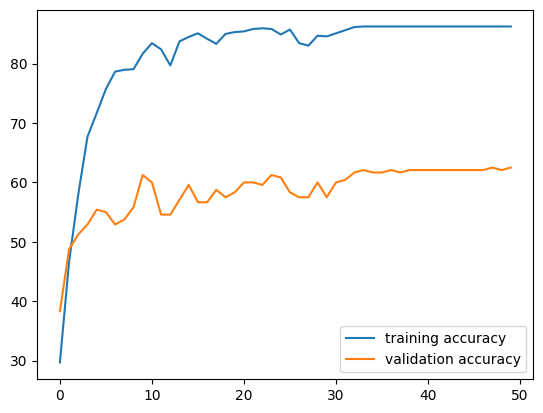

In [19]:
plt.plot(history['train_acc'],label='training accuracy')
plt.plot(history['val_acc'],label = 'validation accuracy')
plt.legend()
plt.show()

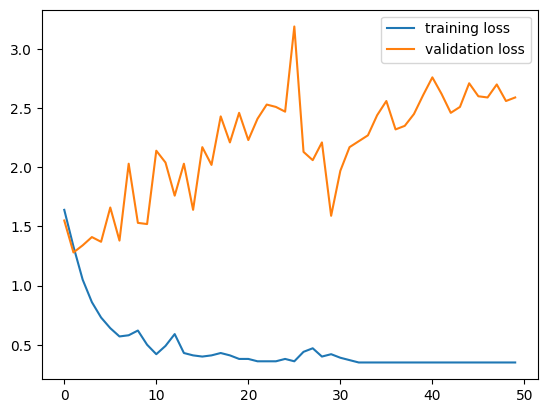

In [20]:
plt.plot(history['train_loss'],label='training loss')
plt.plot(history['val_loss'],label = 'validation loss')
plt.legend()
plt.show()

In [21]:
x_test_tensor = torch.from_numpy(x_test).float()  # Ensure it's float
y_test_tensor = torch.from_numpy(y_test).float()   # Ensure it's long (for classification)
# Create DataLoader
x_test_tensor = x_test_tensor.permute(0, 3, 1, 2)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)
batch_size = 32  # Choose an appropriate batch size
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [24]:
model.eval()
correct_val=0.0
total_val = 0.0
val_loss = 0.0
with torch.no_grad():
    for images, labels in tqdm(test_loader,total=len(test_loader),desc="Validation"):
        images, labels = images.to(device), labels.to(device)
        # print(images.shape)
        outputs = model(images)
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total_train+=labels.size(0)
        labels_class_indices = torch.argmax(labels, dim=1)
        loss = criterion(outputs,labels)
        val_loss+=loss
        correct_val+=(predicted == labels_class_indices).sum().item()
        total_val+=labels.size(0)
    val_accuracy = 100 * correct_val / total_val
    print(f'testing Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss/len(test_loader)}')

Validation: 100%|██████████████████████████████| 18/18 [00:02<00:00,  7.70it/s]

testing Accuracy: 56.97%, Validation Loss: 3.2457754611968994
